In [95]:
import os
import torch
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import  to_networkx

In [96]:
import wandb
wandb.login()

True

In [97]:
datapath = "../../../datasets/"

In [98]:
run = 1
wandb.init( project = 'fedgdrop',
        name=f'metis-degree-dist-vis-v{run}' 
    )

In [99]:
def torch_load(base_dir, filename):
    fpath = os.path.join(base_dir, filename)    
    return torch.load(fpath, map_location=torch.device('cpu'))

def get_degree_list(x):
    G = to_networkx(x, to_undirected=True)
    degrees = [val for (node, val) in G.degree()]
    return degrees

In [100]:
def wandb_save_boxplot(x, n_clients, dset, title , key, lim):
    fig, ax = plt.subplots()
    ax.axes.set_xlim(left = -5, right = lim)
    ax.boxplot(x.values(), vert = False)
    for client_id in range(n_clients):
        ds = f'{client_id}-{dset}'
        ax.scatter(x = x[ds] + np.random.normal(loc =0, scale= 0.05, size = len(x[ds])), y=np.random.normal(loc = client_id+1, scale= 0.15, size = len(x[ds])))    
    ax.set_title(title)
    wandb.log({key : wandb.Image(plt)})

In [101]:
def wandb_save_hist(x, n_clients, k, dset , key, nbins = 50):
    fig, axs = plt.subplots(n_clients // k , k )
    vals , bins = np.zeros((n_clients, nbins)) , np.zeros((n_clients, nbins + 1))
    fig.tight_layout()
    for client_id in range(n_clients):
        ds = f'{client_id}-{dset}'
        if n_clients // k == 1 :
            vals[client_id , :], bins[client_id , :], _ = axs[client_id].hist(x[ds], nbins, density = True)
            axs[client_id].set_title(f"Client {client_id+1}")
        else:
            vals[client_id , :], bins[client_id , :], _ = axs[client_id // k , client_id % k].hist(x[ds], nbins, density = True)
            axs[client_id // k , client_id % k].set_title(f"Client {client_id+1}")
    wandb.log({key : wandb.Image(plt)})
    return vals, bins

In [102]:
def hellinger_dot(p, q):
    """Hellinger distance between two discrete distributions. 
       Using numpy.
       For Python >= 3.5 only"""
    z = np.sqrt(p) - np.sqrt(q)
    return np.sqrt(z @ z / 2)

def wandb_pairwise_hellinger(vals, n_clients, key, title):
    pwise_hell = np.zeros((n_clients, n_clients))

    for i in range(n_clients):
        for j in range(n_clients):
            pwise_hell[i,j] = hellinger_dot(vals[i,:]/sum(vals[i,:]), vals[j,:]/sum(vals[j,:]))
    #Plot the heatmap
    print(f"The Min HD: {np.min(pwise_hell)}")
    print(f"The Max HD: {np.max(pwise_hell)}")
    print(f"Average Off-Diagonal HD: {np.mean(pwise_hell[np.where(~np.eye(pwise_hell.shape[0],dtype=bool))])}")
    plt.matshow(pwise_hell)
    plt.colorbar(location="bottom")
    plt.title(title)
    plt.tight_layout()
    wandb.log({key : wandb.Image(plt)})

In [103]:
def wandb_pairwise_emd(vals, bins, n_clients, key, title):
    pwise_emd = np.zeros((n_clients, n_clients))
    for i in range(n_clients):
        for j in range(n_clients):
            pwise_emd[i,j] = wasserstein_distance(bins[i,:-1], bins[j,:-1], vals[i,:], vals[j,:])
    #Plot the heatmap
    print(f"The Min EMD: {np.min(pwise_emd)}")
    print(f"The Max EMD: {np.max(pwise_emd)}")
    print(f"Average Off-Diagonal EMD: {np.mean(pwise_emd[np.where(~np.eye(pwise_emd.shape[0],dtype=bool))])}")
    plt.matshow(pwise_emd)
    plt.colorbar(location="bottom")
    plt.title(title)
    plt.tight_layout()
    wandb.log({key : wandb.Image(plt)})

## Cora Dataset

### Degree Distribution of Cora Dataset

In [10]:
dataset = Planetoid(root=datapath, name='Cora')
data = dataset[0]

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


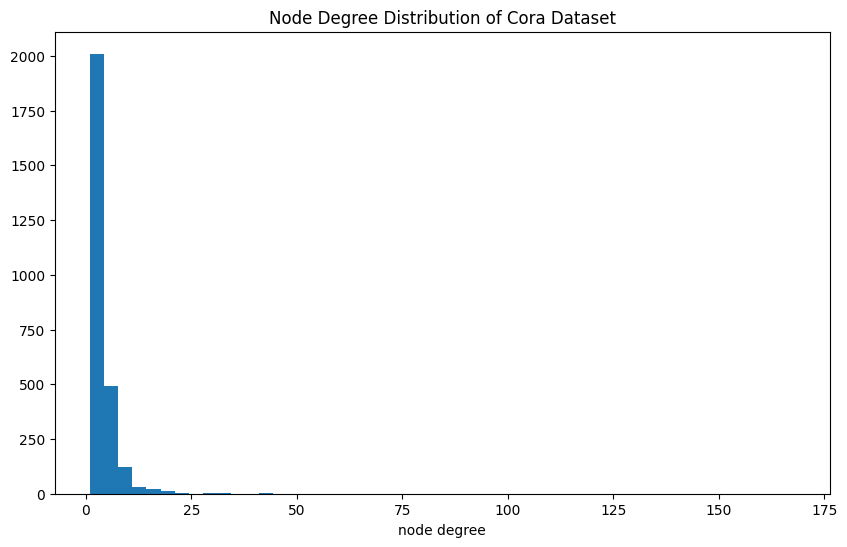

In [11]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.title("Node Degree Distribution of Cora Dataset")
plt.show()

### Clients' Degree Distribution via Boxplots
#### 5 Clients - v1

In [10]:
n_clients = 5
degreev1_dict_cora5 =  {}

In [11]:
for client_id in range(n_clients):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v1_METIS/{n_clients}/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_dict_cora5[ds] = list(comb)

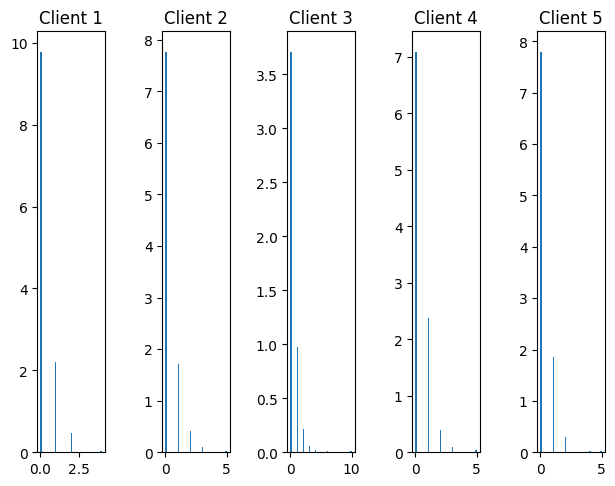

In [12]:
val5, bins5 = wandb_save_hist(degreev1_dict_cora5, n_clients, 5, 'Cora', 'cora5-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 0.502141008296499
Average Off-Diagonal HD: 0.328777627499209


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


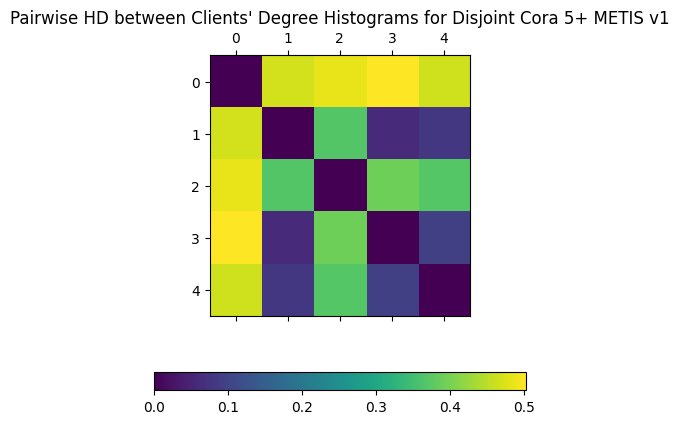

In [13]:
t = "Pairwise HD between Clients' Degree Histograms for Disjoint Cora 5+ METIS v1"
wandb_pairwise_hellinger(val5, 5,'cora5-degree-v1_hd' , t)

The Min EMD: 0.0
The Max EMD: 0.11180950243292487
Average Off-Diagonal EMD: 0.07291089225997083


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


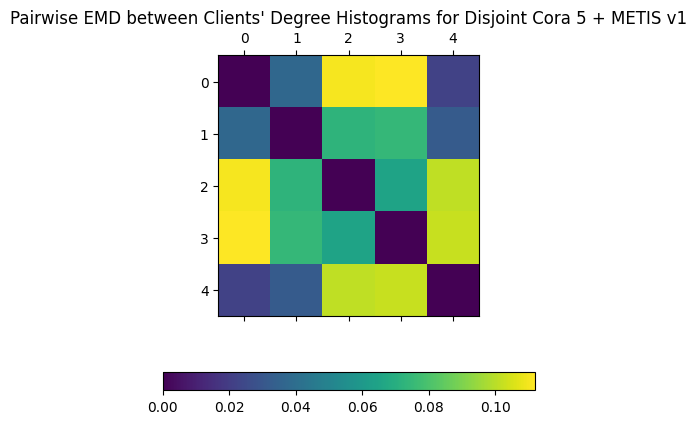

In [14]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 5 + METIS v1"
wandb_pairwise_emd(val5, bins5, 5, 'cora5-degree-v1_emd' , t)

#### 5 Clients - v2

In [15]:
degreev2_dict_cora5 = {}
for client_id in range(5):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v2_METIS/5/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_cora5[ds] = get_degree_list(data)
 

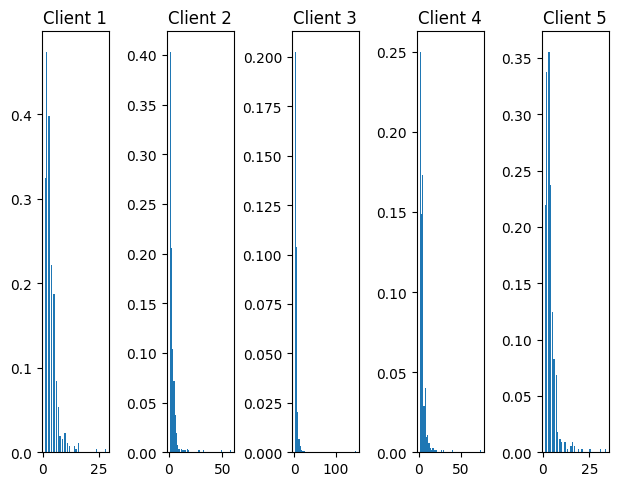

In [16]:
vals_Cora5_v2 , bins_Cora5_v2 = wandb_save_hist(degreev2_dict_cora5, 5, 5, 'Cora', 'cora5-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.5650424953223063
Average Off-Diagonal HD: 0.429226596358831


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


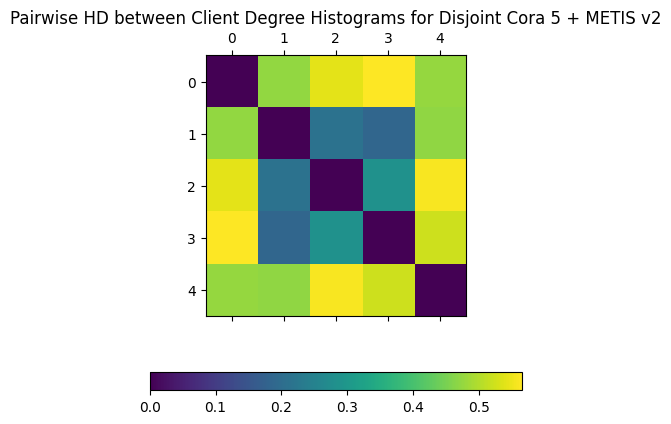

In [17]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Cora 5 + METIS v2"
wandb_pairwise_hellinger(vals_Cora5_v2 , 5, 'cora5-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 1.2343289608804218
Average Off-Diagonal EMD: 0.8320014536548541


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


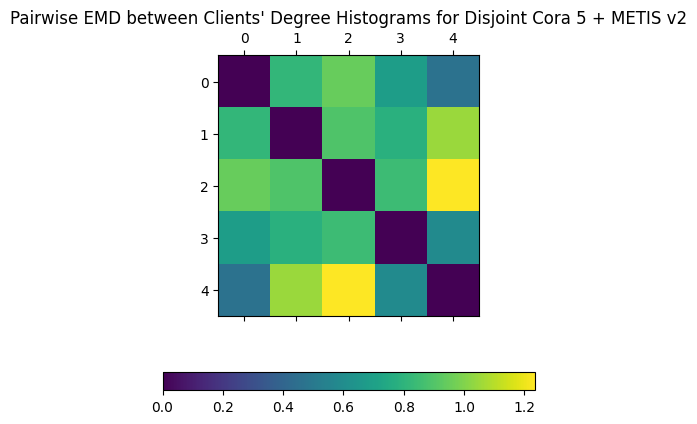

In [18]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 5 + METIS v2"
wandb_pairwise_emd(vals_Cora5_v2 , bins_Cora5_v2, 5, 'cora5-degree-v2_emd' , t)

#### 10 Clients - v1

In [19]:
n_clients = 10
degreev1_dict_cora10 =   {}

In [20]:
for client_id in range(10):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v1_METIS/10/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_dict_cora10[ds] = list(comb)

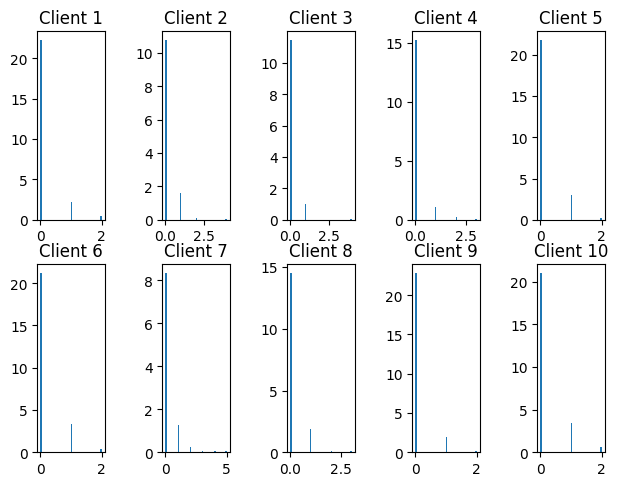

In [21]:
vals_cora10_v1, bins_cora10_v1 = wandb_save_hist(degreev1_dict_cora10, 10, 5, 'Cora', 'cora10-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 0.3909323879509003
Average Off-Diagonal HD: 0.2599775378307154


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


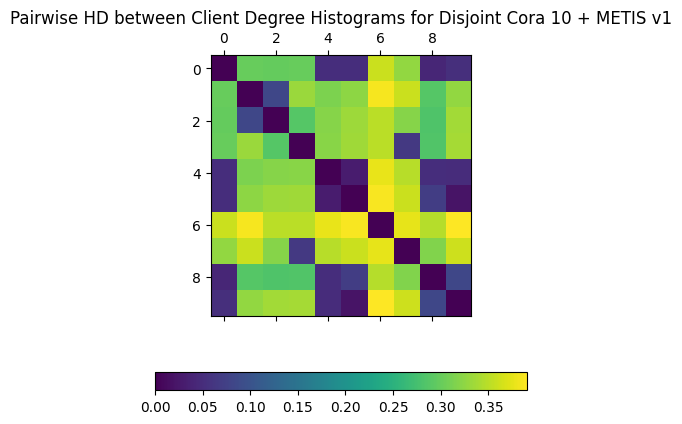

In [22]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Cora 10 + METIS v1"
wandb_pairwise_hellinger(vals_cora10_v1 , 10, 'cora5-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 0.13122999745999556
Average Off-Diagonal EMD: 0.05672620813832512


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


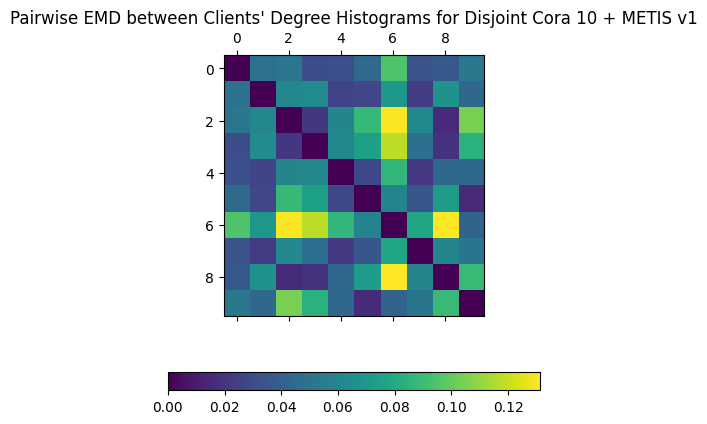

In [23]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 10 + METIS v1"
wandb_pairwise_emd(vals_cora10_v1, bins_cora10_v1, 10, 'cora10-degree-v1_emd' , t)

#### 10 Clients- v2

In [24]:
degreev2_dict_cora10 = {}
for client_id in range(10):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v2_METIS/10/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_cora10[ds] = get_degree_list(data)
 

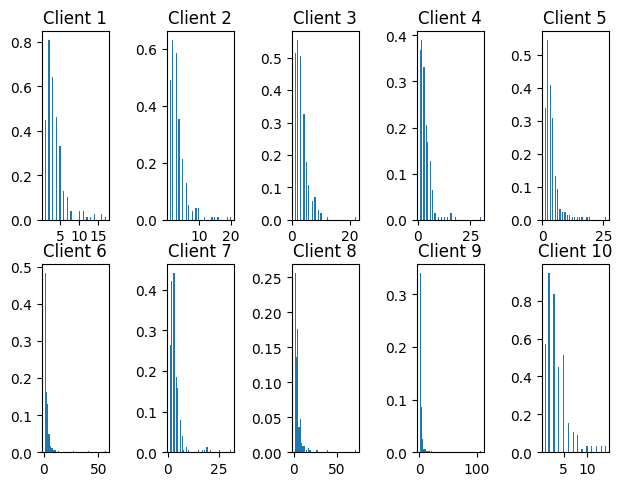

In [25]:
vals_cora10_v2, bins_cora_10_v2 = wandb_save_hist(degreev2_dict_cora10, 10, 5, 'Cora', 'cora10-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.9033612398878775
Average Off-Diagonal HD: 0.6507764350585602


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


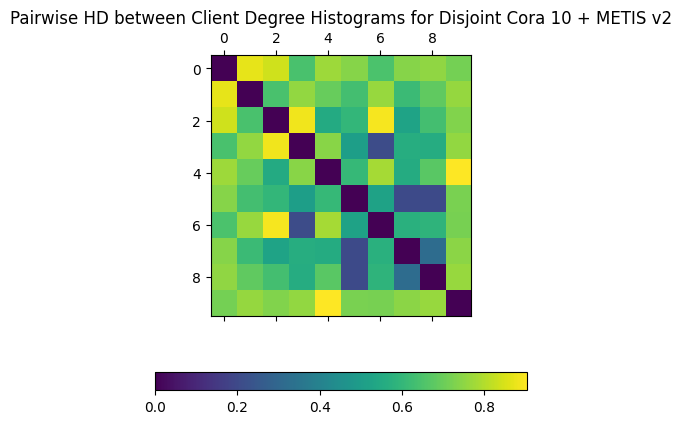

In [26]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Cora 10 + METIS v2"
wandb_pairwise_hellinger(vals_cora10_v2 , 10, 'cora10-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 1.869851930195669
Average Off-Diagonal EMD: 0.8780515958698215


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


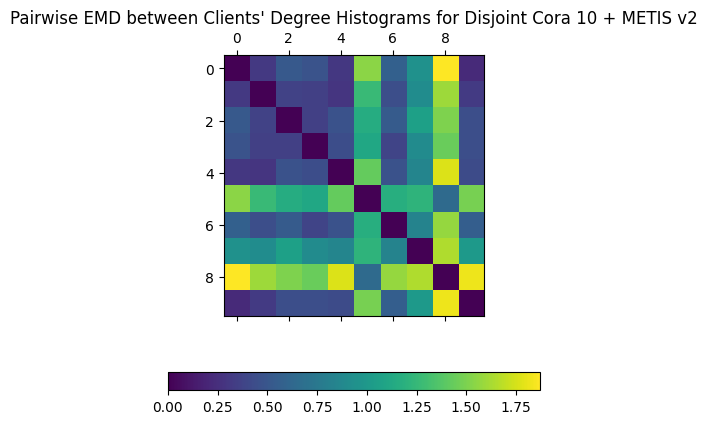

In [27]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 10 + METIS v2"
wandb_pairwise_emd(vals_cora10_v2, bins_cora_10_v2, 10, 'cora10-degree-v2_emd' , t)

#### 20 Clients - v1

In [28]:
n_clients = 20
degreev1_dict_cora20 =  {}

In [29]:
for client_id in range(n_clients):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v1_METIS/{n_clients}/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_dict_cora20[ds] = list(comb)

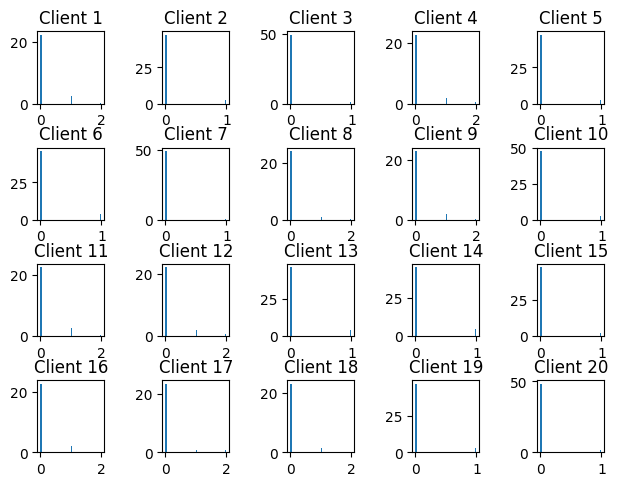

In [30]:
vals_cora20_v1, bins_cora20_v1 = wandb_save_hist(degreev1_dict_cora20, n_clients, 5, 'Cora', 'cora20-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 0.27013998514533727
Average Off-Diagonal HD: 0.13354587261889128


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


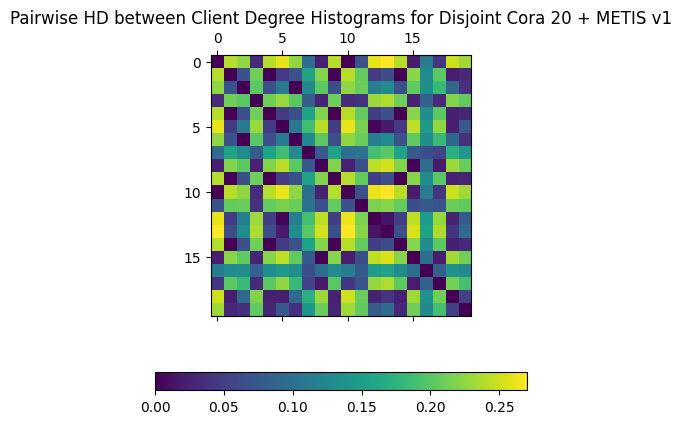

In [31]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Cora 20 + METIS v1"
wandb_pairwise_hellinger(vals_cora20_v1 , 20, 'cora20-degree-v1_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 0.12923419879360076
Average Off-Diagonal EMD: 0.04408828174292073


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


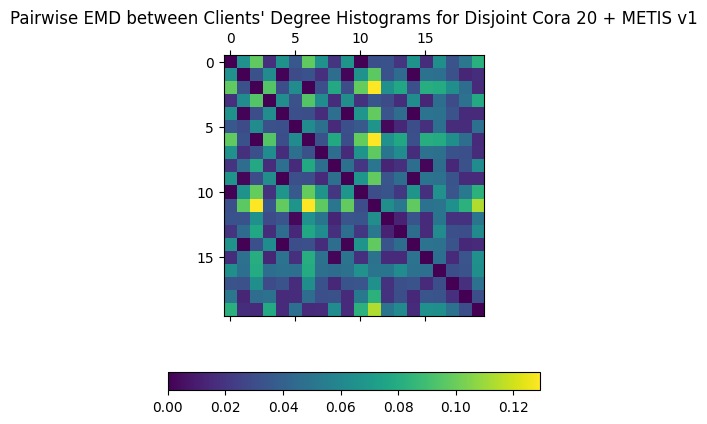

In [32]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 20 + METIS v1"
wandb_pairwise_emd(vals_cora20_v1, bins_cora20_v1, n_clients, 'cora20-degree-v1_emd' , t)

#### 20 Clients - v2 

In [33]:
degreev2_dict_cora20 = {}
for client_id in range(n_clients):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v2_METIS/{n_clients}/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_cora20[ds] = get_degree_list(data)
 

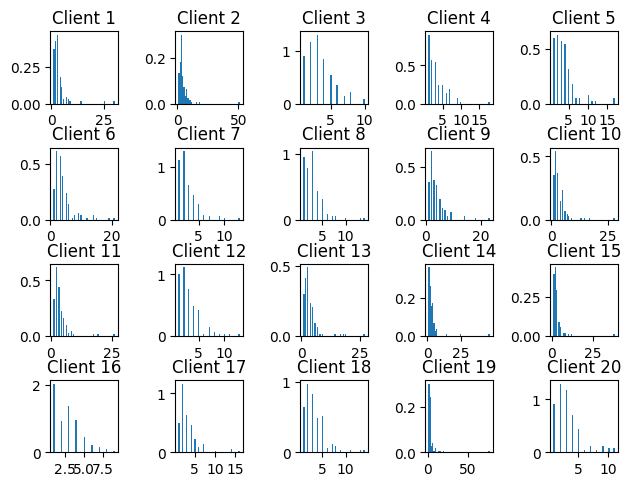

In [34]:
vals_cora20_v2, bins_cora20_v2 =wandb_save_hist(degreev2_dict_cora20, n_clients, 5, 'Cora', 'cora20-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.908892511797302
Average Off-Diagonal HD: 0.7197840841183599


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


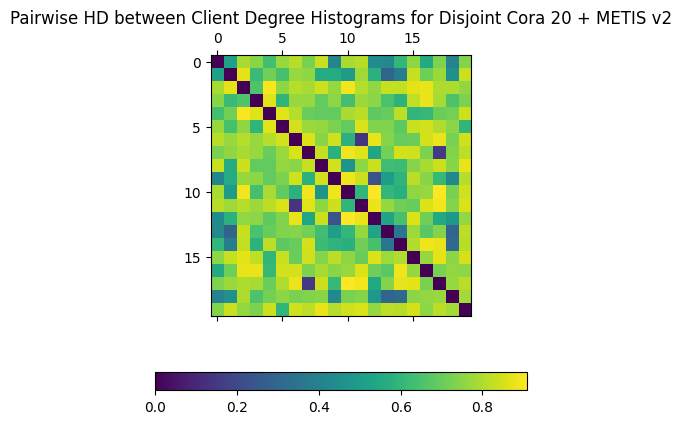

In [35]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Cora 20 + METIS v2"
wandb_pairwise_hellinger(vals_cora20_v2 , 20, 'cora20-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 1.6257684862562907
Average Off-Diagonal EMD: 0.7560416100278342


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


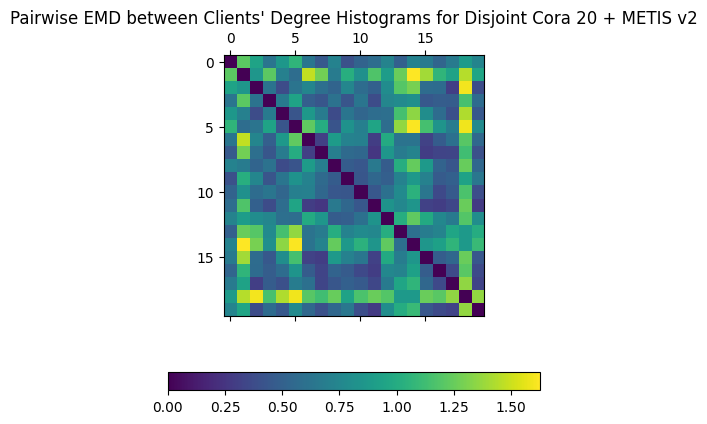

In [36]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 20 + METIS v2"
wandb_pairwise_emd(vals_cora20_v2, bins_cora20_v2, n_clients, 'cora20-degree-v2_emd' , t)

## CiteSeer Dataset


,count,mean,std,min,25%,50%,75%,max
0,3327.0,2.74,3.38,0.0,1.0,2.0,3.0,99.0


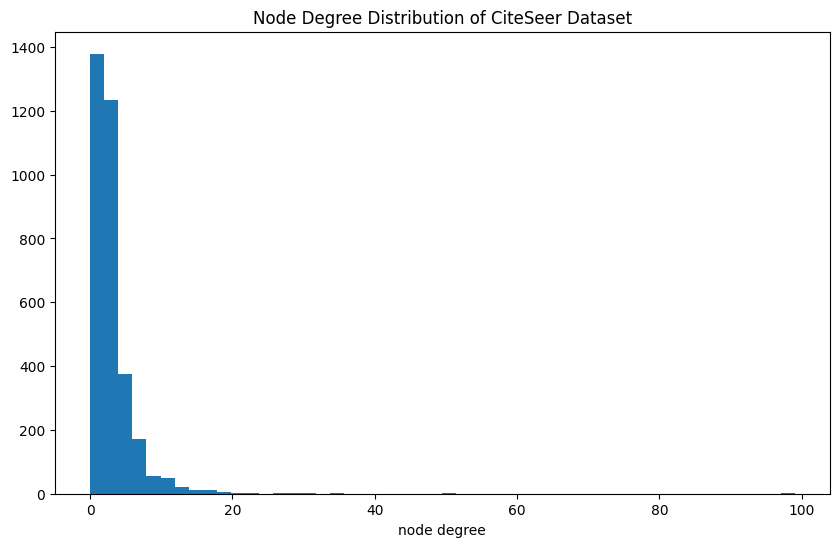

In [37]:
dataset = Planetoid(root=datapath, name='CiteSeer')
data = dataset[0]
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.title("Node Degree Distribution of CiteSeer Dataset")
plt.show()

#### 5 Clients - v1

In [38]:
n_clients = 5
degreev1_seer5  =  {}

In [39]:
for client_id in range(n_clients):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'CiteSeer_disjoint_v1_METIS/{n_clients}/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_seer5[ds] = list(comb)

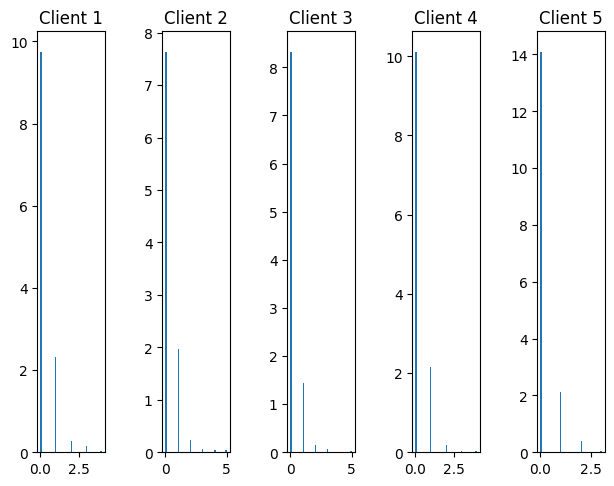

In [40]:
vals_seer5_v1, bins_seer5_v1 =wandb_save_hist(degreev1_seer5, n_clients, 5, 'CiteSeer', 'seer5-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 0.47394486031926103
Average Off-Diagonal HD: 0.35948037473926026


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


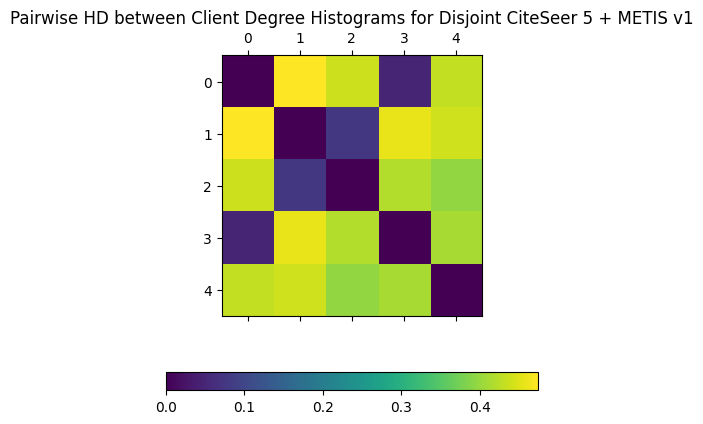

In [41]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 5 + METIS v1"
wandb_pairwise_hellinger(vals_seer5_v1 , 5, 'seer5-degree-v1_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 0.12812143874643842
Average Off-Diagonal EMD: 0.07015286825198411


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


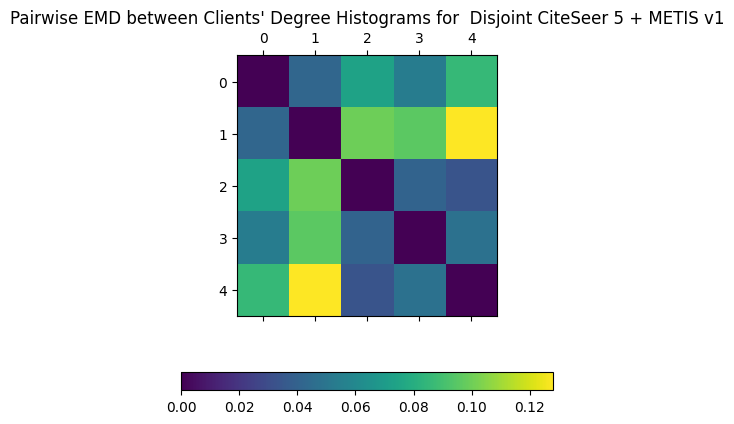

In [42]:
t = "Pairwise EMD between Clients' Degree Histograms for  Disjoint CiteSeer 5 + METIS v1"
wandb_pairwise_emd(vals_seer5_v1, bins_seer5_v1, 5,  'seer5-degree-v1_emd' , t)

#### 5 Clients - v2

In [43]:
degreev2_dict_seer5 =  {}
for client_id in range(n_clients):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'CiteSeer_disjoint_v2_METIS/5/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        data = partition['client_data']
        degreev2_dict_seer5[ds] = get_degree_list(data)


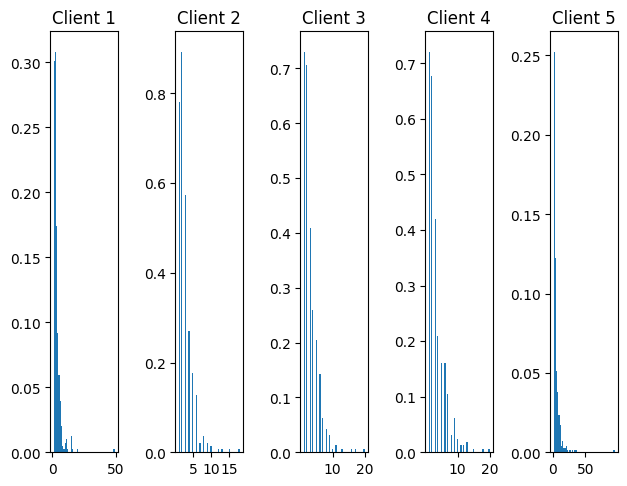

In [44]:
vals_seer5_v2, bins_seer5_v2 =wandb_save_hist(degreev2_dict_seer5, n_clients, 5, 'CiteSeer', 'seer5-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.6144500909567221
Average Off-Diagonal HD: 0.4864042767902764


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


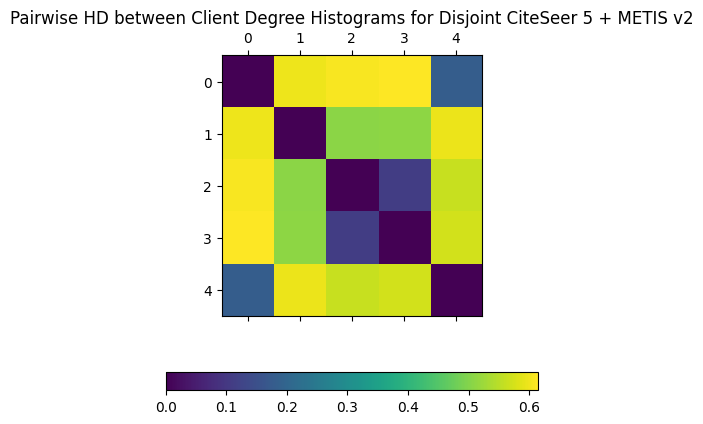

In [45]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 5 + METIS v2"
wandb_pairwise_hellinger(vals_seer5_v2 , 5, 'seer5-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 1.616797956804189
Average Off-Diagonal EMD: 0.7831050971895642


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


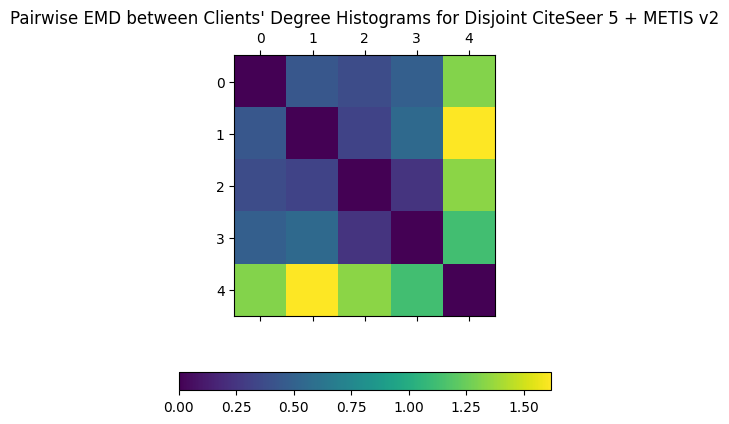

In [46]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint CiteSeer 5 + METIS v2"
wandb_pairwise_emd(vals_seer5_v2, bins_seer5_v2, 5, 'seer5-degree-v2_emd' , t)

#### 10 Clients - v1

In [47]:
n_clients = 10
degreev1_dict_seer10 =  {}

In [48]:
for client_id in range(n_clients):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'CiteSeer_disjoint_v1_METIS/{n_clients}/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_dict_seer10[ds] = list(comb)

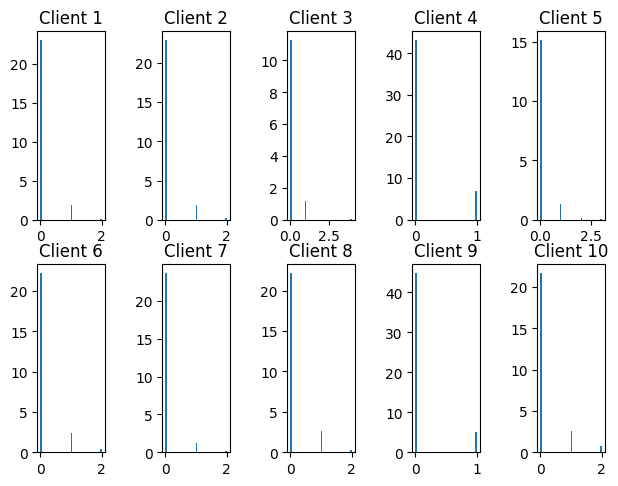

In [49]:
vals_seer10_v1, bins_seer10_v1 =wandb_save_hist(degreev1_dict_seer10, n_clients,5, 'CiteSeer', 'seer10-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 0.3067809001879099
Average Off-Diagonal HD: 0.2663328228433862


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


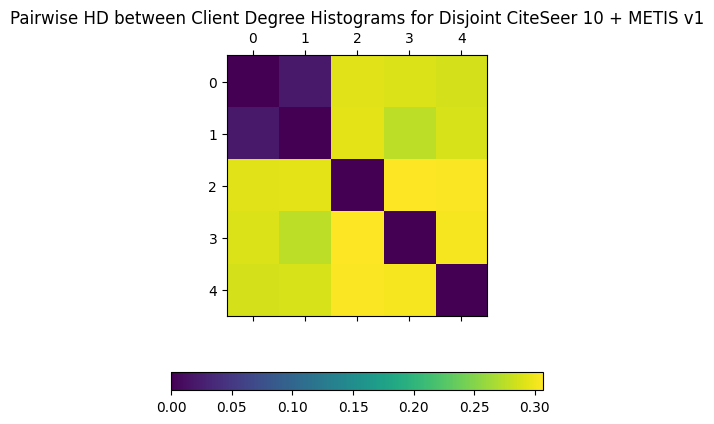

In [50]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 10 + METIS v1"
wandb_pairwise_hellinger(vals_seer10_v1 , 5, 'seer5-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 0.10309504827708374
Average Off-Diagonal EMD: 0.04241209836588479


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


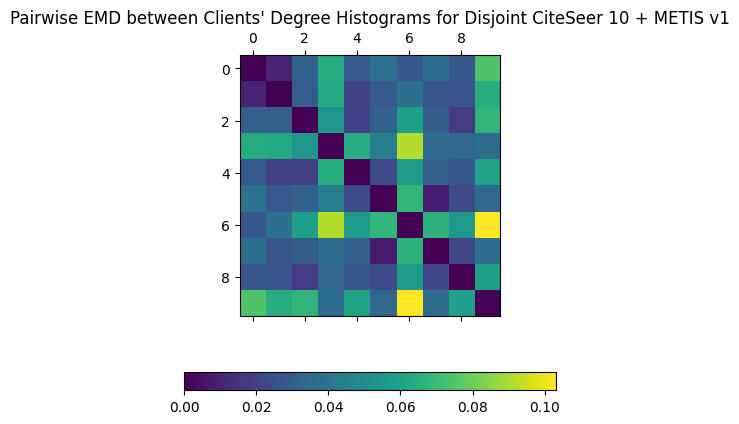

In [51]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint CiteSeer 10 + METIS v1"
wandb_pairwise_emd(vals_seer10_v1, bins_seer10_v1, 10, 'seer10-degree-v1_emd' , t)

#### 10 Clients - v2

In [52]:
degreev2_dict_seer10 =  {}
for client_id in range(n_clients):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'CiteSeer_disjoint_v2_METIS/{n_clients}/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_seer10[ds] = get_degree_list(data)


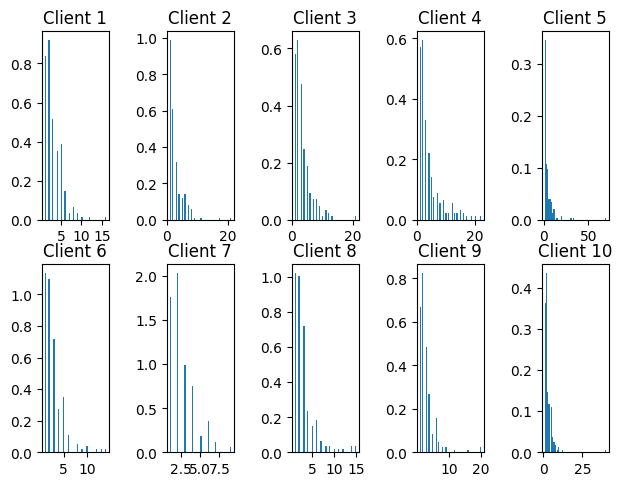

In [53]:
vals_seer10_v2, bins_seer10_v2 =wandb_save_hist(degreev2_dict_seer10, n_clients,5, 'CiteSeer', 'seer10-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.8563111128433853
Average Off-Diagonal HD: 0.6507242554771359


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


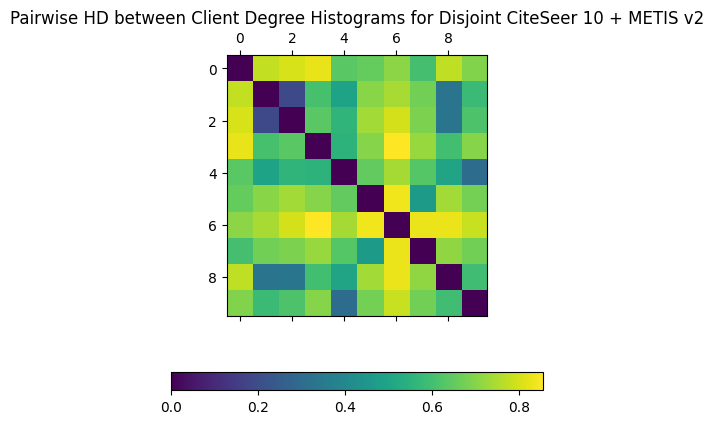

In [54]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 10 + METIS v2"
wandb_pairwise_hellinger(vals_seer10_v2 , 10, 'seer10-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 1.605181773465091
Average Off-Diagonal EMD: 0.7609967301801728


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


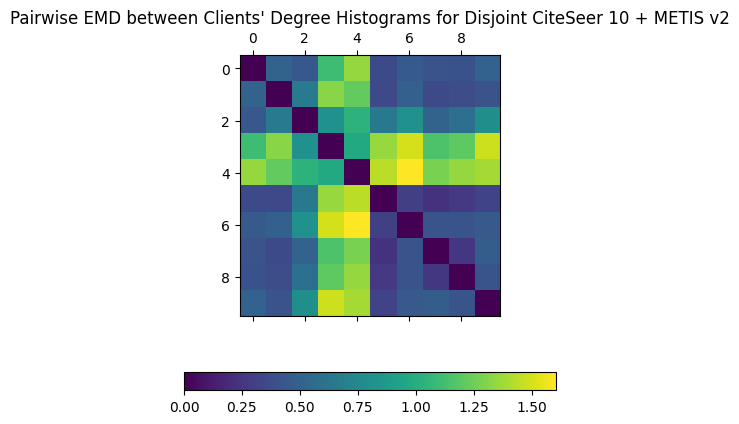

In [55]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint CiteSeer 10 + METIS v2"
wandb_pairwise_emd(vals_seer10_v2, bins_seer10_v2, 10, 'seer10-degree-v2_emd' , t)

#### 20 Clients - v1

In [56]:
n_clients = 20
degreev1_dict_seer20 = {}

In [57]:
for client_id in range(n_clients):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'CiteSeer_disjoint_v1_METIS/{n_clients}/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_dict_seer20[ds] = list(comb)


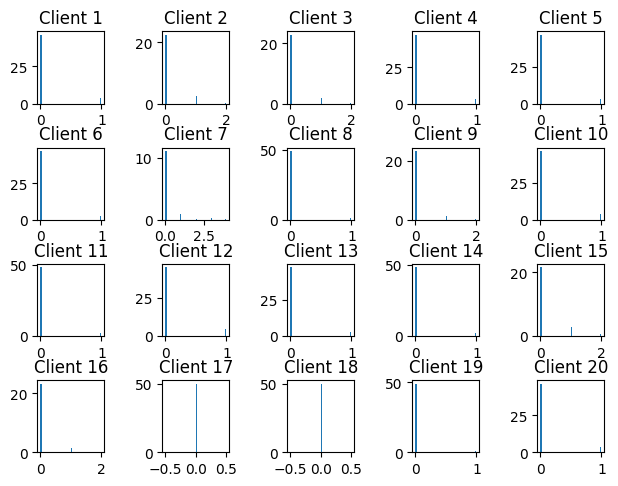

In [58]:
vals_seer20_v1, bins_seer20_v1 =wandb_save_hist(degreev1_dict_seer20, n_clients,5, 'CiteSeer', 'seer20-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 1.0
Average Off-Diagonal HD: 0.2906238007177093


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


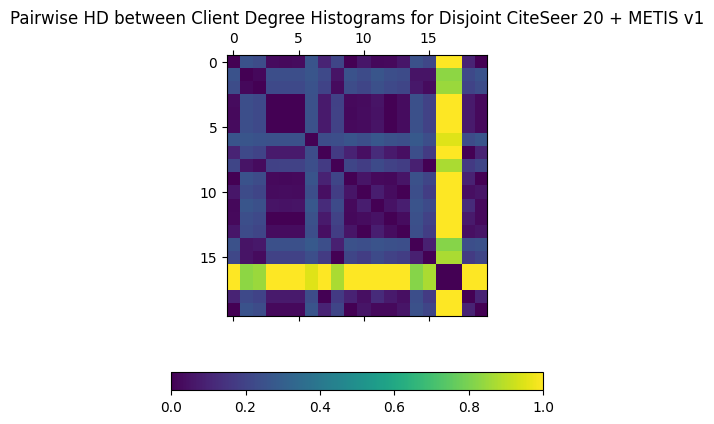

In [59]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 20 + METIS v1"
wandb_pairwise_hellinger(vals_seer20_v1 , 20, 'seer20-degree-v1_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 0.18242990654205601
Average Off-Diagonal EMD: 0.05380872083944061


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


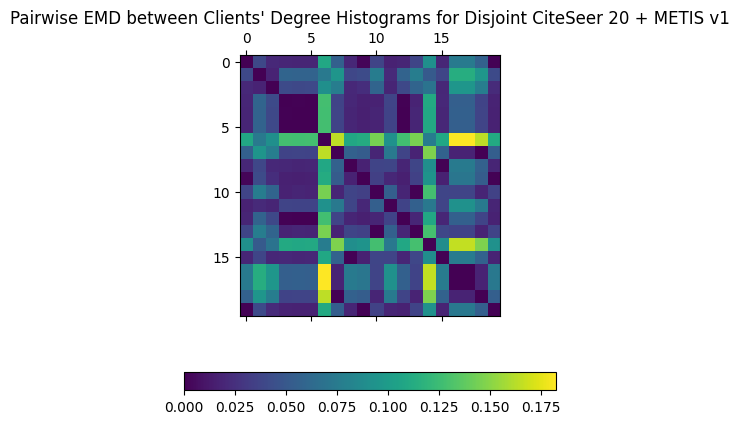

In [60]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint CiteSeer 20 + METIS v1"
wandb_pairwise_emd(vals_seer20_v1, bins_seer20_v1, 20, 'seer20-degree-v1_emd' , t)

#### 20 Clients - v2

In [61]:
degreev2_dict_seer20 =   {}
for client_id in range(n_clients):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'CiteSeer_disjoint_v2_METIS/{n_clients}/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_seer20[ds] = get_degree_list(data)



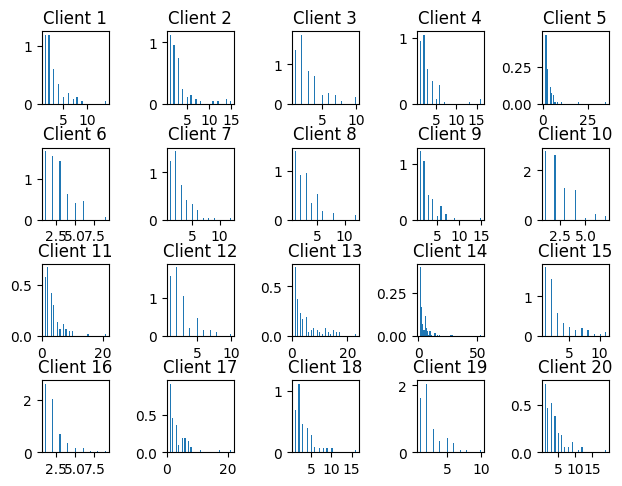

In [62]:
vals_seer20_v2, bins_seer20_v2 =wandb_save_hist(degreev2_dict_seer20, n_clients,5, 'CiteSeer', 'seer20-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.8526173757968588
Average Off-Diagonal HD: 0.7076054692216064


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


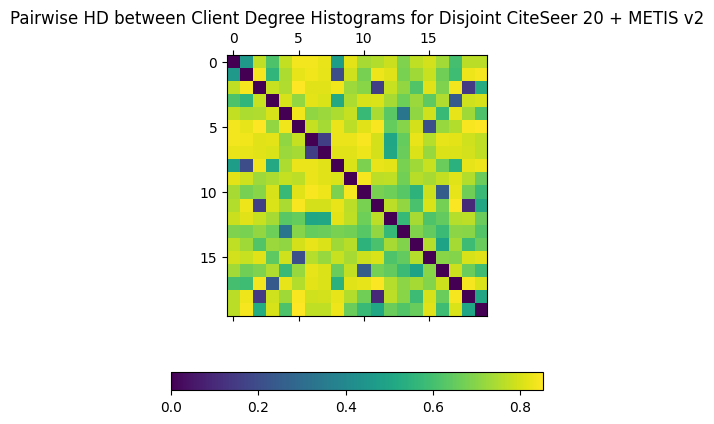

In [63]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 20 + METIS v2"
wandb_pairwise_hellinger(vals_seer20_v2 , 20, 'seer20-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 2.5500505873274455
Average Off-Diagonal EMD: 0.7985172456350692


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


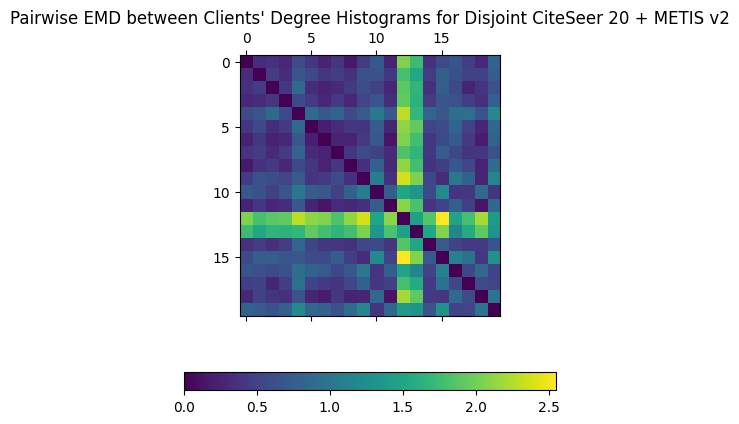

In [64]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint CiteSeer 20 + METIS v2"
wandb_pairwise_emd(vals_seer20_v2, bins_seer20_v2, 20, 'seer20-degree-v2_emd' , t)

## PubMed Dataset

In [65]:
n_clients = 5
degreev1_dict_med5 =  {}

In [66]:
for client_id in range(n_clients):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint/{n_clients}/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_dict_med5[ds] = list(comb)

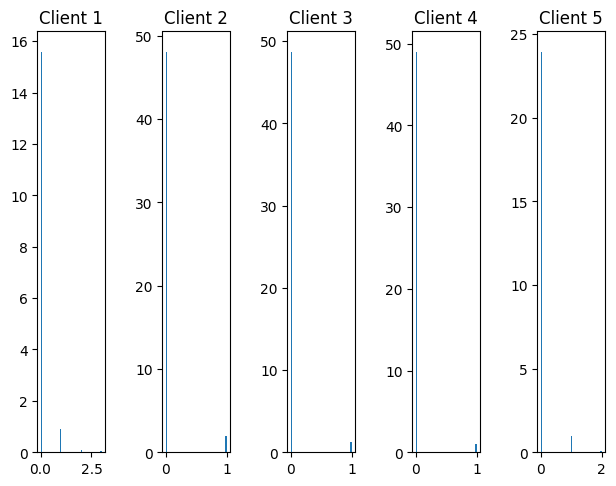

In [67]:
vals_med5_v1, bins_med5_v1 =wandb_save_hist(degreev1_dict_med5, n_clients,5, 'PubMed', 'med5-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 0.22326008994785115
Average Off-Diagonal HD: 0.13588579476282628


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


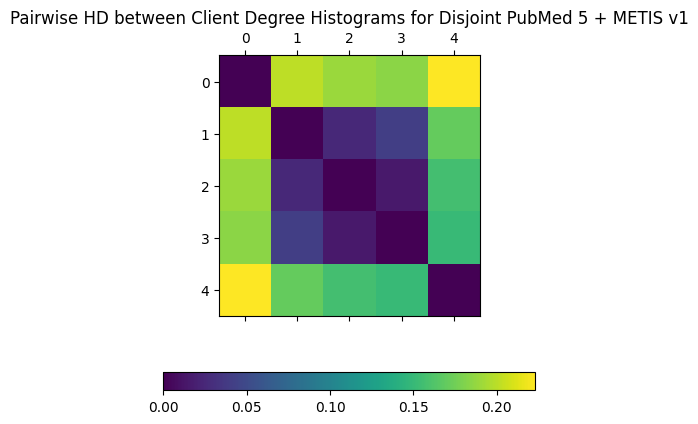

In [68]:
t = "Pairwise HD between Client Degree Histograms for Disjoint PubMed 5 + METIS v1"
wandb_pairwise_hellinger(vals_med5_v1 , 5, 'med5-degree-v1_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 0.0561996042542666
Average Off-Diagonal EMD: 0.026739036455020116


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


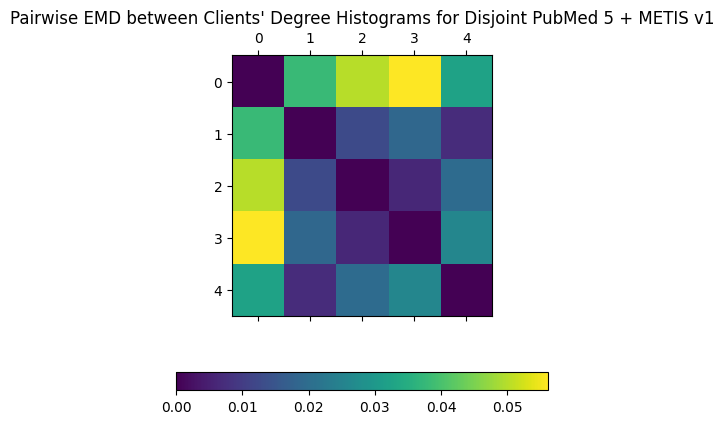

In [69]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint PubMed 5 + METIS v1"
wandb_pairwise_emd(vals_med5_v1, bins_med5_v1, n_clients, 'med5-degree-v1_emd' , t)


#### 5 Clients - v2

In [107]:
degreev2_dict_med5 =   {}
for client_id in range(5):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint_v2_METIS/{5}/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_med5[ds] = get_degree_list(data)

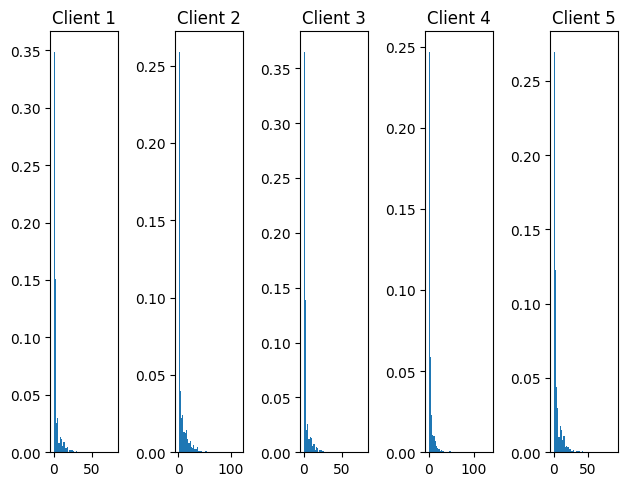

In [108]:
vals_med5_v2, bins_med5_v2 =wandb_save_hist(degreev2_dict_med5, 5,5, 'PubMed', 'med5-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.1739966077377153
Average Off-Diagonal HD: 0.13334753068148186


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


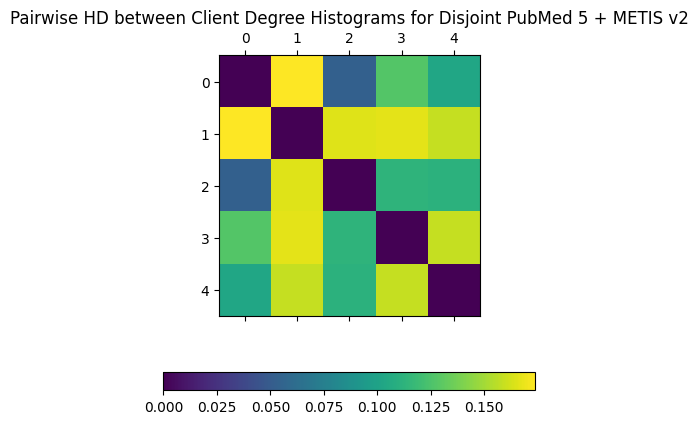

In [109]:
t = "Pairwise HD between Client Degree Histograms for Disjoint PubMed 5 + METIS v2"
wandb_pairwise_hellinger(vals_med5_v2 , 5, 'med5-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 3.650500686868144
Average Off-Diagonal EMD: 1.793453454531278


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


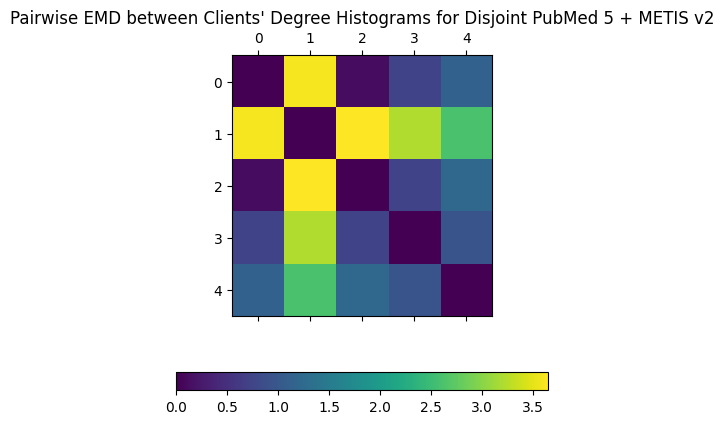

In [111]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint PubMed 5 + METIS v2"
wandb_pairwise_emd(vals_med5_v2, bins_med5_v2, 5, 'med5-degree-v2_emd' , t)


#### 10 Clients - v1

In [74]:
n_clients = 10
degreev1_dict_med10 =  {}

In [75]:
for client_id in range(n_clients):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint/{n_clients}/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_dict_med10[ds] = list(comb)


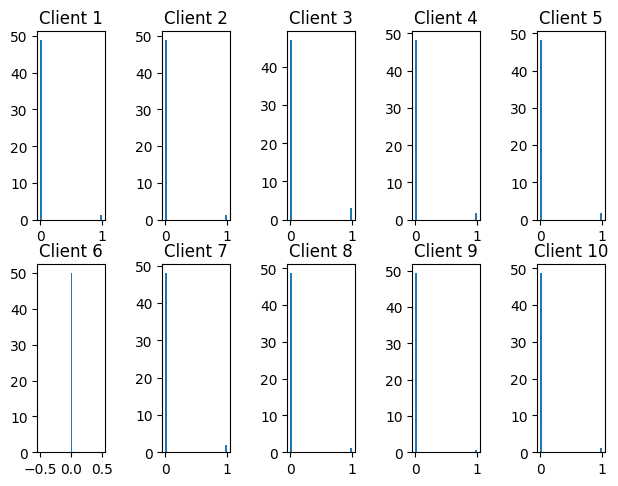

In [76]:
vals_med10_v1, bins_med10_v1 =wandb_save_hist(degreev1_dict_med10, n_clients,5, 'PubMed', 'med10-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 1.0
Average Off-Diagonal HD: 0.22482443956180628


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


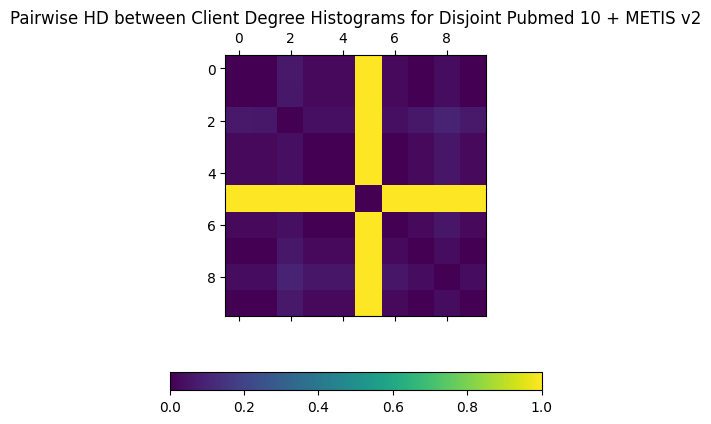

In [77]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Pubmed 10 + METIS v2"
wandb_pairwise_hellinger(vals_med10_v1 , 10, 'med10-degree-v1_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 0.06242038216560508
Average Off-Diagonal EMD: 0.018692807716600573


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


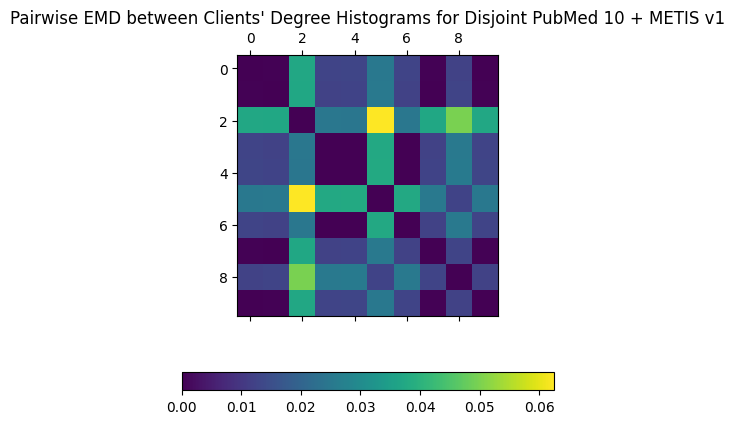

In [78]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint PubMed 10 + METIS v1"
wandb_pairwise_emd(vals_med10_v1, bins_med10_v1, n_clients, 'med10-degree-v1_emd' , t)


#### 10 Clients- v2

In [112]:
degreev2_dict_med10 =   {}
for client_id in range(10):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint_v2_METIS/10/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_med10[ds] = get_degree_list(data)

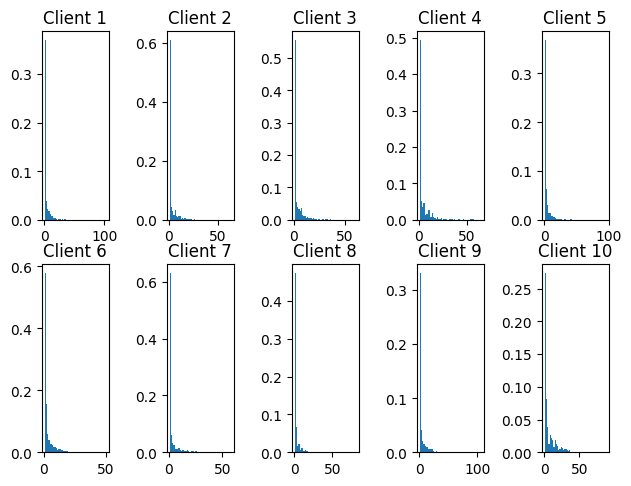

In [113]:
vals_med10_v2, bins_med10_v2 =wandb_save_hist(degreev2_dict_med10, 10,5, 'PubMed', 'med10-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.2626627382752264
Average Off-Diagonal HD: 0.1515010421464937


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


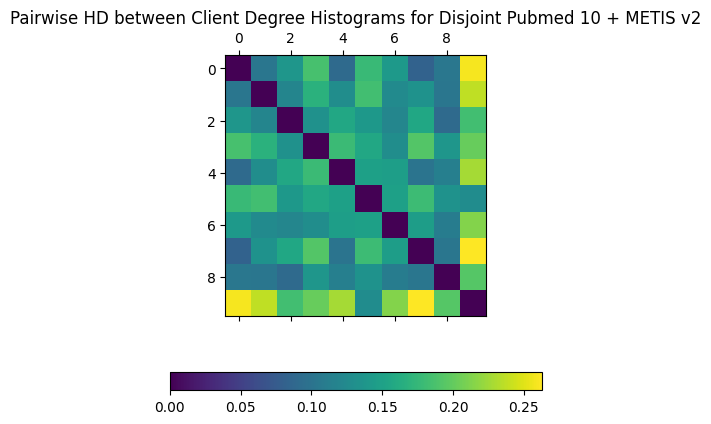

In [114]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Pubmed 10 + METIS v2"
wandb_pairwise_hellinger(vals_med10_v2 , 10, 'med10-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 4.168225406777154
Average Off-Diagonal EMD: 1.334184072421263


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


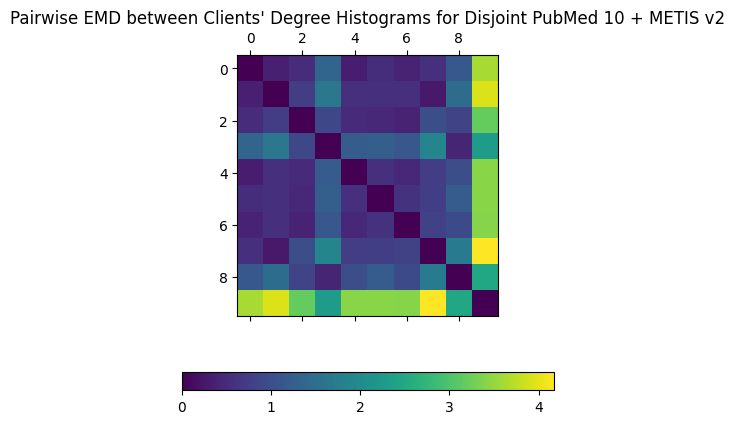

In [115]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint PubMed 10 + METIS v2"
wandb_pairwise_emd(vals_med10_v2, bins_med10_v2, 10, 'med10-degree-v2_emd' , t)


#### 20 Clients - v1

In [83]:
n_clients = 20
degreev1_dict_med20 =  {}

In [84]:
for client_id in range(n_clients):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint/{n_clients}/partition_{client_id}.pt')
        #Data objects
        tr, val, tst = partition['client_tr'], partition['client_val'] , partition['client_tst']
        comb = chain(get_degree_list(tr), get_degree_list(val) , get_degree_list(tst))
        degreev1_dict_med20[ds] = list(comb)


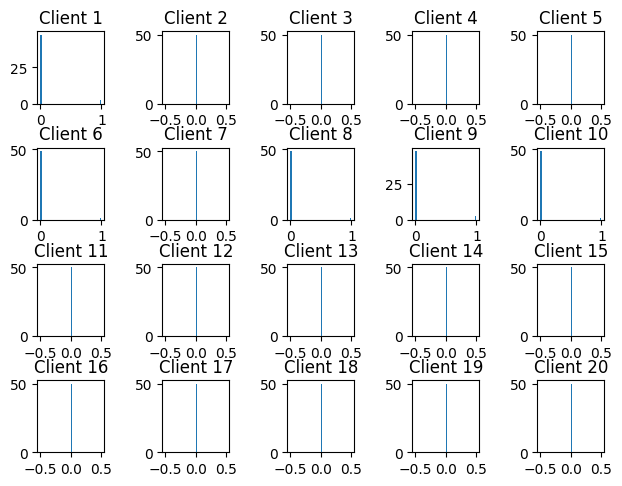

In [85]:
vals_med20_v1, bins_med20_v1 =wandb_save_hist(degreev1_dict_med20, n_clients,5, 'PubMed', 'med20-degree-v1-hist', 50)

The Min HD: 0.0
The Max HD: 1.0
Average Off-Diagonal HD: 0.3963838610877483


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


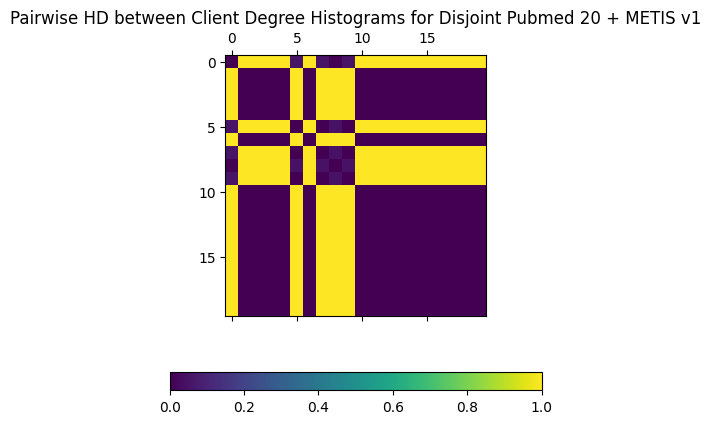

In [86]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Pubmed 20 + METIS v1"
wandb_pairwise_hellinger(vals_med20_v1, 20, 'med20-degree-v1_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 0.05297297297297298
Average Off-Diagonal EMD: 0.014897937073375667


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


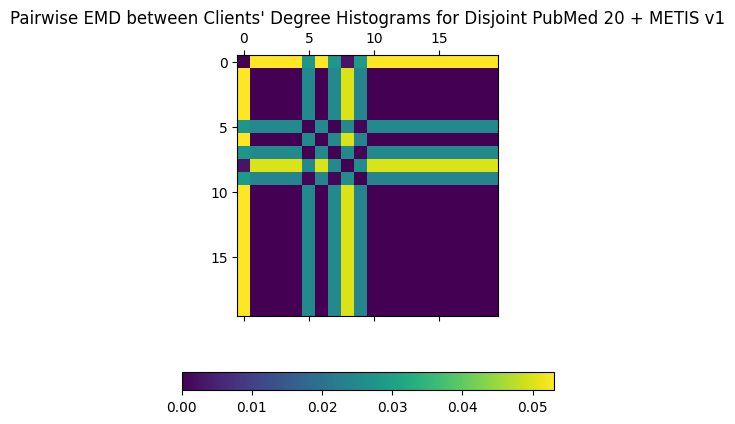

In [87]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint PubMed 20 + METIS v1"
wandb_pairwise_emd(vals_med20_v1, bins_med20_v1 , n_clients, 'med20-degree-v1_emd' , t)


#### 20 Clients - v2

In [116]:
degreev2_dict_med20 =   {}
for client_id in range(20):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint_v2_METIS/20/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_med20[ds] = get_degree_list(data)

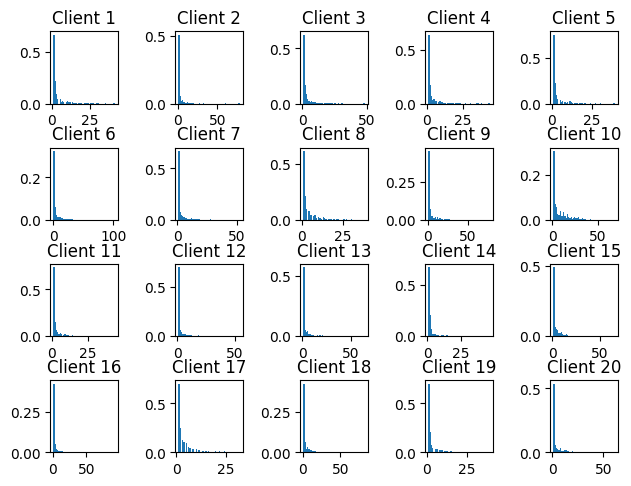

In [117]:
vals_med20_v2, bins_med20_v2 =wandb_save_hist(degreev2_dict_med20, 20,5, 'PubMed', 'med20-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.4383031485742522
Average Off-Diagonal HD: 0.22791637044751617


/tmp/ipykernel_66025/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


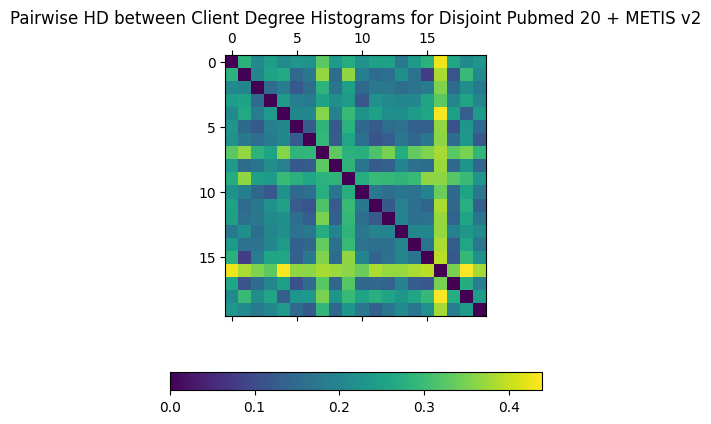

In [118]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Pubmed 20 + METIS v2"
wandb_pairwise_hellinger(vals_med20_v2, 20, 'med20-degree-v2_hellinger', t)

The Min EMD: 0.0
The Max EMD: 2.5500505873274455
Average Off-Diagonal EMD: 0.7985172456350692


/tmp/ipykernel_66025/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


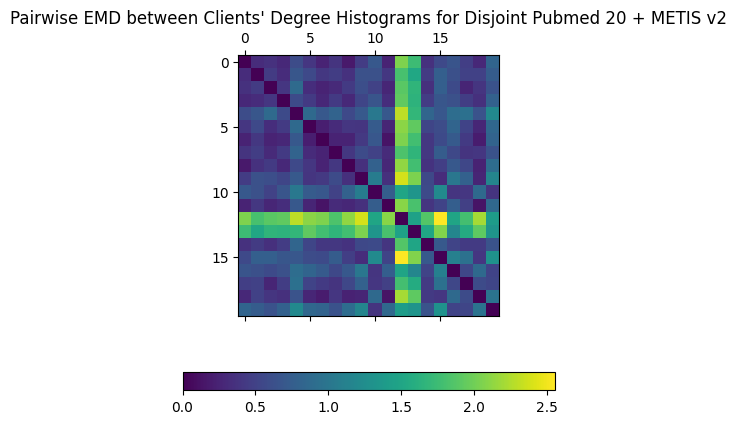

In [91]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Pubmed 20 + METIS v2"
wandb_pairwise_emd(vals_med20_v2, bins_med20_v2, n_clients, 'med20-degree-v2_emd' , t)


In [119]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
